In [ ]:
# In this project we will (i) generate some data from a mixture of Gaussians (MoG) model, and 
# (ii) fit a MoG model to the generated data, in order to recover the original parameters. 

In [1]:
# Import the necessary libraries
%load_ext autoreload
%autoreload 2

import sys
import time

import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from construct_data_mod import construct_data, drawGaussianOutline

flt_min = sys.float_info.min

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Define the true parameters for a mixture of  𝐾=3  Gaussians. We are representing the mixture 
# of Gaussians as a dictionary. The 'weight' field is a list of weights  𝜋𝑖  for each mixture component i
mixGaussTrue = dict()
mixGaussTrue['K'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[4.0491, 4.8597],
                                 [7.7578, 1.6335],
                                 [11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'], mixGaussTrue['d'], mixGaussTrue['K']))
mixGaussTrue['cov'][:,:,0] = np.array([[4.2534, 0.4791],
                                       [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[0.9729, 0.8723],
                                       [0.8723, 2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[0.9886, -1.2244],
                                       [-1.2244, 3.0187]])

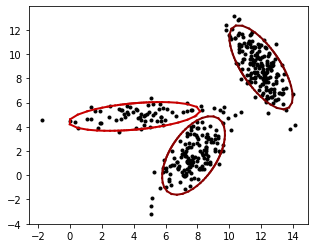

In [3]:
# Define the number of samples to generate
nData = 400

# This function generates data from a k-dimensional mixture of Gaussians structure.
def mixGaussGen(mixGauss, nData):
    np.random.seed(123)

    # allocate space for output data
    data = np.zeros(shape=(mixGauss['d'], nData))
    for cData in range(nData):
        # randomly choose a Gaussian component according to the probability distribution
        h = np.random.choice(mixGauss['K'], p=mixGauss['weight'])
        # draw a sample from the sampled Gaussian distribution
        curMean = mixGauss['mean'][:,h]
        curCov = mixGauss['cov'][:,:,h]
        data[:, cData] = np.random.multivariate_normal(curMean, curCov)
    
    return data

def drawEMData2d(ax, data, mixGauss, title_text=""):
    ax.plot(data[0,:], data[1,:], 'k.')
    ax.set_title(title_text)
    for cGauss in range(mixGauss['K']):
        drawGaussianOutline(ax,
                            mixGauss['mean'][:,cGauss],
                            mixGauss['cov'][:,:,cGauss],
                            mixGauss['weight'][cGauss])
    return

# generate data points from the mixture of Gaussians
data = mixGaussGen(mixGaussTrue,nData)

# draw data, MOG distributions
fig, ax = plt.subplots()
drawEMData2d(ax, data, mixGaussTrue)

In [4]:
# Calculate the probability density of the mixture of Gaussians
def mixGaussPDF(data, mixGaussEst):
    data = np.atleast_2d(data)
    nDims, nData = data.shape
    if nDims != mixGaussEst['d']:
        print('Error! Wrong number of dimensions for data!')
    
    K = mixGaussEst['K']
    weight = mixGaussEst['weight']
    mean = mixGaussEst['mean']
    cov = mixGaussEst['cov']
    probDensity = 0
    for i in range(K):
        normal_pdf = multivariate_normal.pdf(data.T, mean = mean[:, i], cov = cov[:, :, i])
        probDensity += weight[i] * normal_pdf
    return probDensity

In [5]:
# Calculate the log likelihood of the mixture of Gaussians
def getMixGaussLogLikelihood(data, mixGaussEst):
    data = np.atleast_2d(data)
    probDensity = mixGaussPDF (data, mixGaussEst)
    logLike = np.sum(np.log(probDensity))
    
    return np.asscalar(logLike)

In [6]:
# Fit the EM algorithm
def fitMixGauss(data, K, nIter=20):
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(K, nData))

    # In the E-M algorithm, we calculate a complete posterior distribution over each of
    # the (nData) hidden variables in the E-Step.  In the M-Step, we
    # update the parameters of the Gaussians (mean, cov, w).

    # Initialize parameters
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['K'] = K
    mixGaussEst['weight'] = np.full(shape=K, fill_value=1/K)
    # Initialize means and covariances using data statistics
    mean_data = np.mean(data, axis=1).reshape(nDims, 1)
    mixGaussEst['mean'] = (1 + 0.1*np.random.normal(size=(nDims, K))) * mean_data
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, K))
    cov_data = np.cov(data)
    for k in range(K):
        mixGaussEst['cov'][:, :, k] = cov_data * (1 +  0.1*np.random.normal())

    # Calculate current likelihood
    logLikelihoodsList = []
    logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLikehood))
    logLikelihoodsList.append(logLikehood)

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):
        # Expectation step
        for i in range(nData):
            xi = data[:, i]
            for k in range(K):
                curWeight = mixGaussEst['weight'][k]
                curMean = mixGaussEst['mean'][:, k]
                curCov = mixGaussEst['cov'][:, :, k]
                postHidden[k, i] = curWeight * multivariate_normal.pdf(xi, mean = curMean, cov = curCov)
            postHidden[:, i] /= (np.sum(postHidden[:, i]) + flt_min)
            
        # Maximization Step
        for k in range(K):
            mixGaussEst['weight'][k] = np.sum(postHidden[k, :]) / np.sum(postHidden)
            mixGaussEst['mean'][:,k] = np.dot(postHidden[k, :], data.T) / np.sum(postHidden[k, :])
            x_bar = data - mixGaussEst['mean'][:, k].reshape(2, 1)
            mixGaussEst['cov'][:,:,k] = (x_bar @ np.diag(postHidden[k, :]) @ x_bar.T) / np.sum(postHidden[k, :])

        # Draw the new solution
        title_text = "EM: Iteration {}".format(cIter)
        ax.clear()
        drawEMData2d(ax, data, mixGaussEst, title_text)
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(0.1)

        # Calculate the log likelihood
        logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
        logLikelihoodsList.append(logLikehood)
    
    # Plot the likelihood after each iteration
    fig, ax = plt.subplots()
    ax.plot(logLikelihoodsList)
    ax.set_xlabel('Iteration')
    ax.set_title('Log-Likelihood')

    return mixGaussEst

<ipython-input-5-01397fbd3103>:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(logLike)


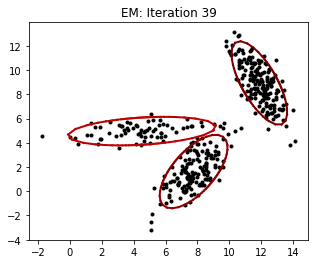

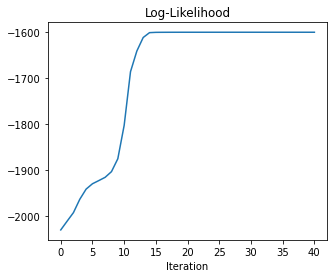

In [7]:
nGaussEst = 3 # no of components to estimate

# fit the mixture of Gaussians
mixGaussEst = fitMixGauss(data, nGaussEst, nIter=40)

In [ ]:
## Use the MOG method for classification

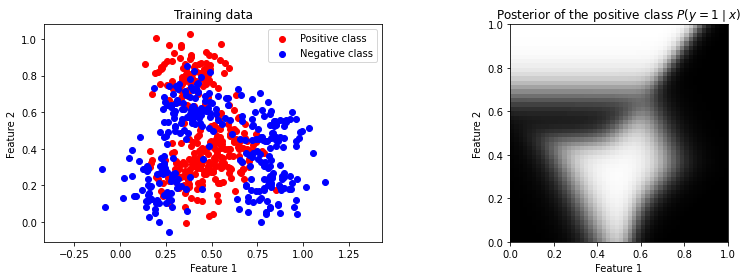

In [8]:
training_features, training_labels, posterior = construct_data(600, 'train', 'nonlinear' , plusminus=False)

# Extract features for both classes
features_pos = training_features[training_labels == 1].T
features_neg = training_features[training_labels != 1].T

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[0,:], features_pos[1,:], c="red", label="Positive class")
ax.scatter(features_neg[0,:], features_neg[1,:], c="blue", label="Negative class")
ax.axis('equal')
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

<ipython-input-5-01397fbd3103>:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(logLike)


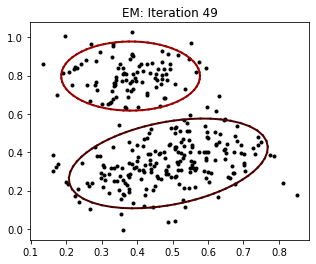

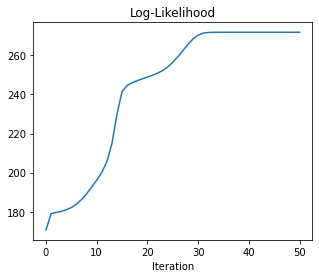

In [11]:
# Based on the plot of the data, it appears that there are 2 components for the positive class and
# 3 components for the negative class. 
numGaussPositiveEst = 2
mixGaussPositiveEst = fitMixGauss(features_pos, numGaussPositiveEst, nIter=50)

<ipython-input-5-01397fbd3103>:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(logLike)


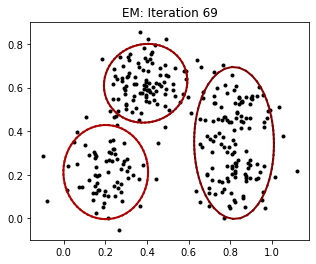

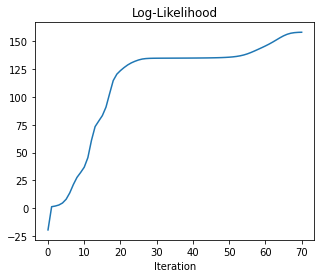

In [12]:
numGaussNegativeEst = 3
mixGaussNegativeEst = fitMixGauss(features_neg, numGaussNegativeEst, nIter=70)

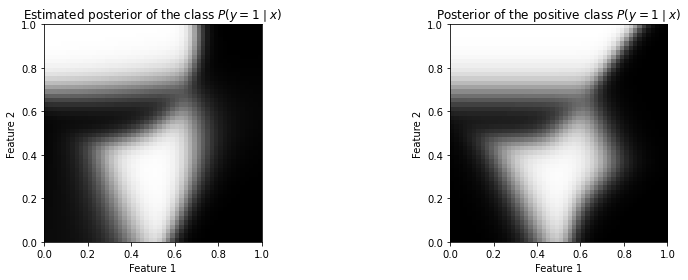

In [13]:
# We use Bayes' rule to calculate the posterior of the positive class and compare it to the actual posterior
x_range = np.linspace(0, 1, 50)
y_range = np.linspace(0, 1, 50)
grid_x, grid_y = np.meshgrid(x_range, y_range)
xy_array = np.row_stack([grid_x.flat, grid_y.flat])

# Prior probabilities for positive and negative class
prior_pos = 0.5
prior_neg = 0.5

# calculate class conditional probabilities for positive and negative class
pos_class_on_grid = mixGaussPDF(xy_array, mixGaussPositiveEst)
neg_class_on_grid = mixGaussPDF(xy_array, mixGaussNegativeEst)

# calculate posterior probabilities for positive class using Bayes' rule
posterior_positive = (pos_class_on_grid * prior_pos) / (pos_class_on_grid * prior_pos + neg_class_on_grid * prior_neg)

# reshape posterior probability to plot it as an image
posterior_positive = posterior_positive.reshape(grid_x.shape)

fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(posterior_positive, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Estimated posterior of the class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()